In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
# Step 1: Data Collection
df = pd.read_csv('dataset.csv')  # Assuming first column is index
df.head()
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [3]:
df.shape

(72946, 9)

In [4]:
# Step 2: Data Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['crypto_name', 'date']).reset_index(drop=True)
df.head()

,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0.000000,0.516571,0.000000,0.516571,0.000000,0.000000e+00,2020-10-02T23:59:59.999Z,Aave,2020-10-02
1,0.523836,65.305938,0.523801,53.151488,0.000000,0.000000e+00,2020-10-03T23:59:59.999Z,Aave,2020-10-03
2,53.179858,55.070355,50.688990,52.675035,0.000000,0.000000e+00,2020-10-04T23:59:59.999Z,Aave,2020-10-04
3,52.675035,55.112358,49.787900,53.219243,0.000000,8.912813e+07,2020-10-05T23:59:59.999Z,Aave,2020-10-05
4,53.291969,53.402270,40.734578,42.401599,583091.459763,7.101144e+07,2020-10-06T23:59:59.999Z,Aave,2020-10-06


In [5]:
df.timestamp.unique()

array(['2020-10-02T23:59:59.999Z', '2020-10-03T23:59:59.999Z',
       '2020-10-04T23:59:59.999Z', ..., '2017-05-29T23:59:59.999Z',
       '2017-05-30T23:59:59.999Z', '2017-05-31T23:59:59.999Z'],
      shape=(3248,), dtype=object)

In [6]:
# Change the timestamp column to datetime format 2020-10-02T23:59:59.999Z to 2020-10-02

df['timestamp'] = pd.to_datetime(df['timestamp']).dt.date
df.timestamp

0        2020-10-02
1        2020-10-03
2        2020-10-04
3        2020-10-05
4        2020-10-06
            ...    
72941    2022-09-25
72942    2022-10-02
72943    2022-10-09
72944    2022-10-16
72945    2022-10-23
Name: timestamp, Length: 72946, dtype: object

In [7]:
# Filter cryptos with >=1000 data points
crypto_counts = df['crypto_name'].value_counts()
selected_cryptos = crypto_counts[crypto_counts >= 1000].index # Select cryptos with >=1000 data points means that they have at least 1000 data points
df = df[df['crypto_name'].isin(selected_cryptos)]
df.shape

(60527, 9)

In [8]:
#  engineer_features function
def engineer_features(df):
    print("Engineering features...")
    
    # Calculate Daily Returns
    df['returns'] = df.groupby('crypto_name')['close'].pct_change()

    # --- Target Variable: Volatility ---
    # We define volatility as the rolling 7-day standard deviation of returns
    df['volatility_7d'] = df.groupby('crypto_name')['returns'].rolling(window=7).std().reset_index(0, drop=True)

    # --- Technical Indicators ---
    # Moving Averages (Price & Volume)
    df['ma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=7).mean())
    df['ma_30'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=30).mean())
    df['volume_ma_7'] = df.groupby('crypto_name')['volume'].transform(lambda x: x.rolling(window=7).mean())
    
    # Liquidity Ratio (Volume / Market Cap)
    df['liquidity_ratio'] = df['volume'] / df['marketCap']

    # Bollinger Bands (Measure of market volatility)
    df['bb_middle'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=20).mean())
    df['bb_std'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=20).std())
    df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']

    # --- Prediction Target ---
    # We want to predict the *next* day's volatility. 
    # We shift the calculated volatility back by 1 day to align features(t) with target(t+1).
    df['target_volatility'] = df.groupby('crypto_name')['volatility_7d'].shift(-1)

    # Clean NaNs created by rolling windows and lagging
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_clean = df.dropna()
    
    print(f"Features created. Cleaned data shape: {df_clean.shape}")
    return df_clean

In [9]:
df=engineer_features(df)

Engineering features...
Features created. Cleaned data shape: (58095, 21)


In [10]:
df.columns.unique()


Index(['open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp',
       'crypto_name', 'date', 'returns', 'volatility_7d', 'ma_7', 'ma_30',
       'volume_ma_7', 'liquidity_ratio', 'bb_middle', 'bb_std', 'bb_upper',
       'bb_lower', 'bb_width', 'target_volatility'],
      dtype='object')

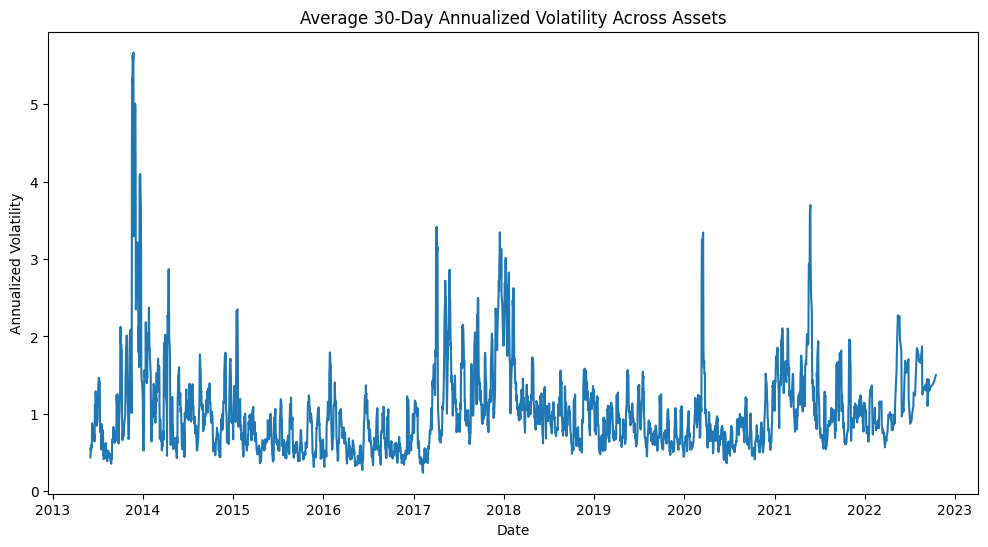

In [11]:
# Step 4: EDA (Example for aggregate or top asset)
# Aggregate Volatility Trend (example)
# Step 5: Model Training
numerical_features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'returns', 'ma_7', 'ma_30', 'volume_ma_7', 'liquidity_ratio', 'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bb_width']
categorical_features = ['crypto_name']

agg_vol = df.groupby('date')['volatility_7d'].mean() * np.sqrt(365)
plt.figure(figsize=(12, 6))
plt.plot(agg_vol.index, agg_vol.values)
plt.title('Average 30-Day Annualized Volatility Across Assets')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()  # This will display the plot in your notebook
plt.savefig('agg_vol_trend.png')  # Optional: Still saves to file
plt.close()




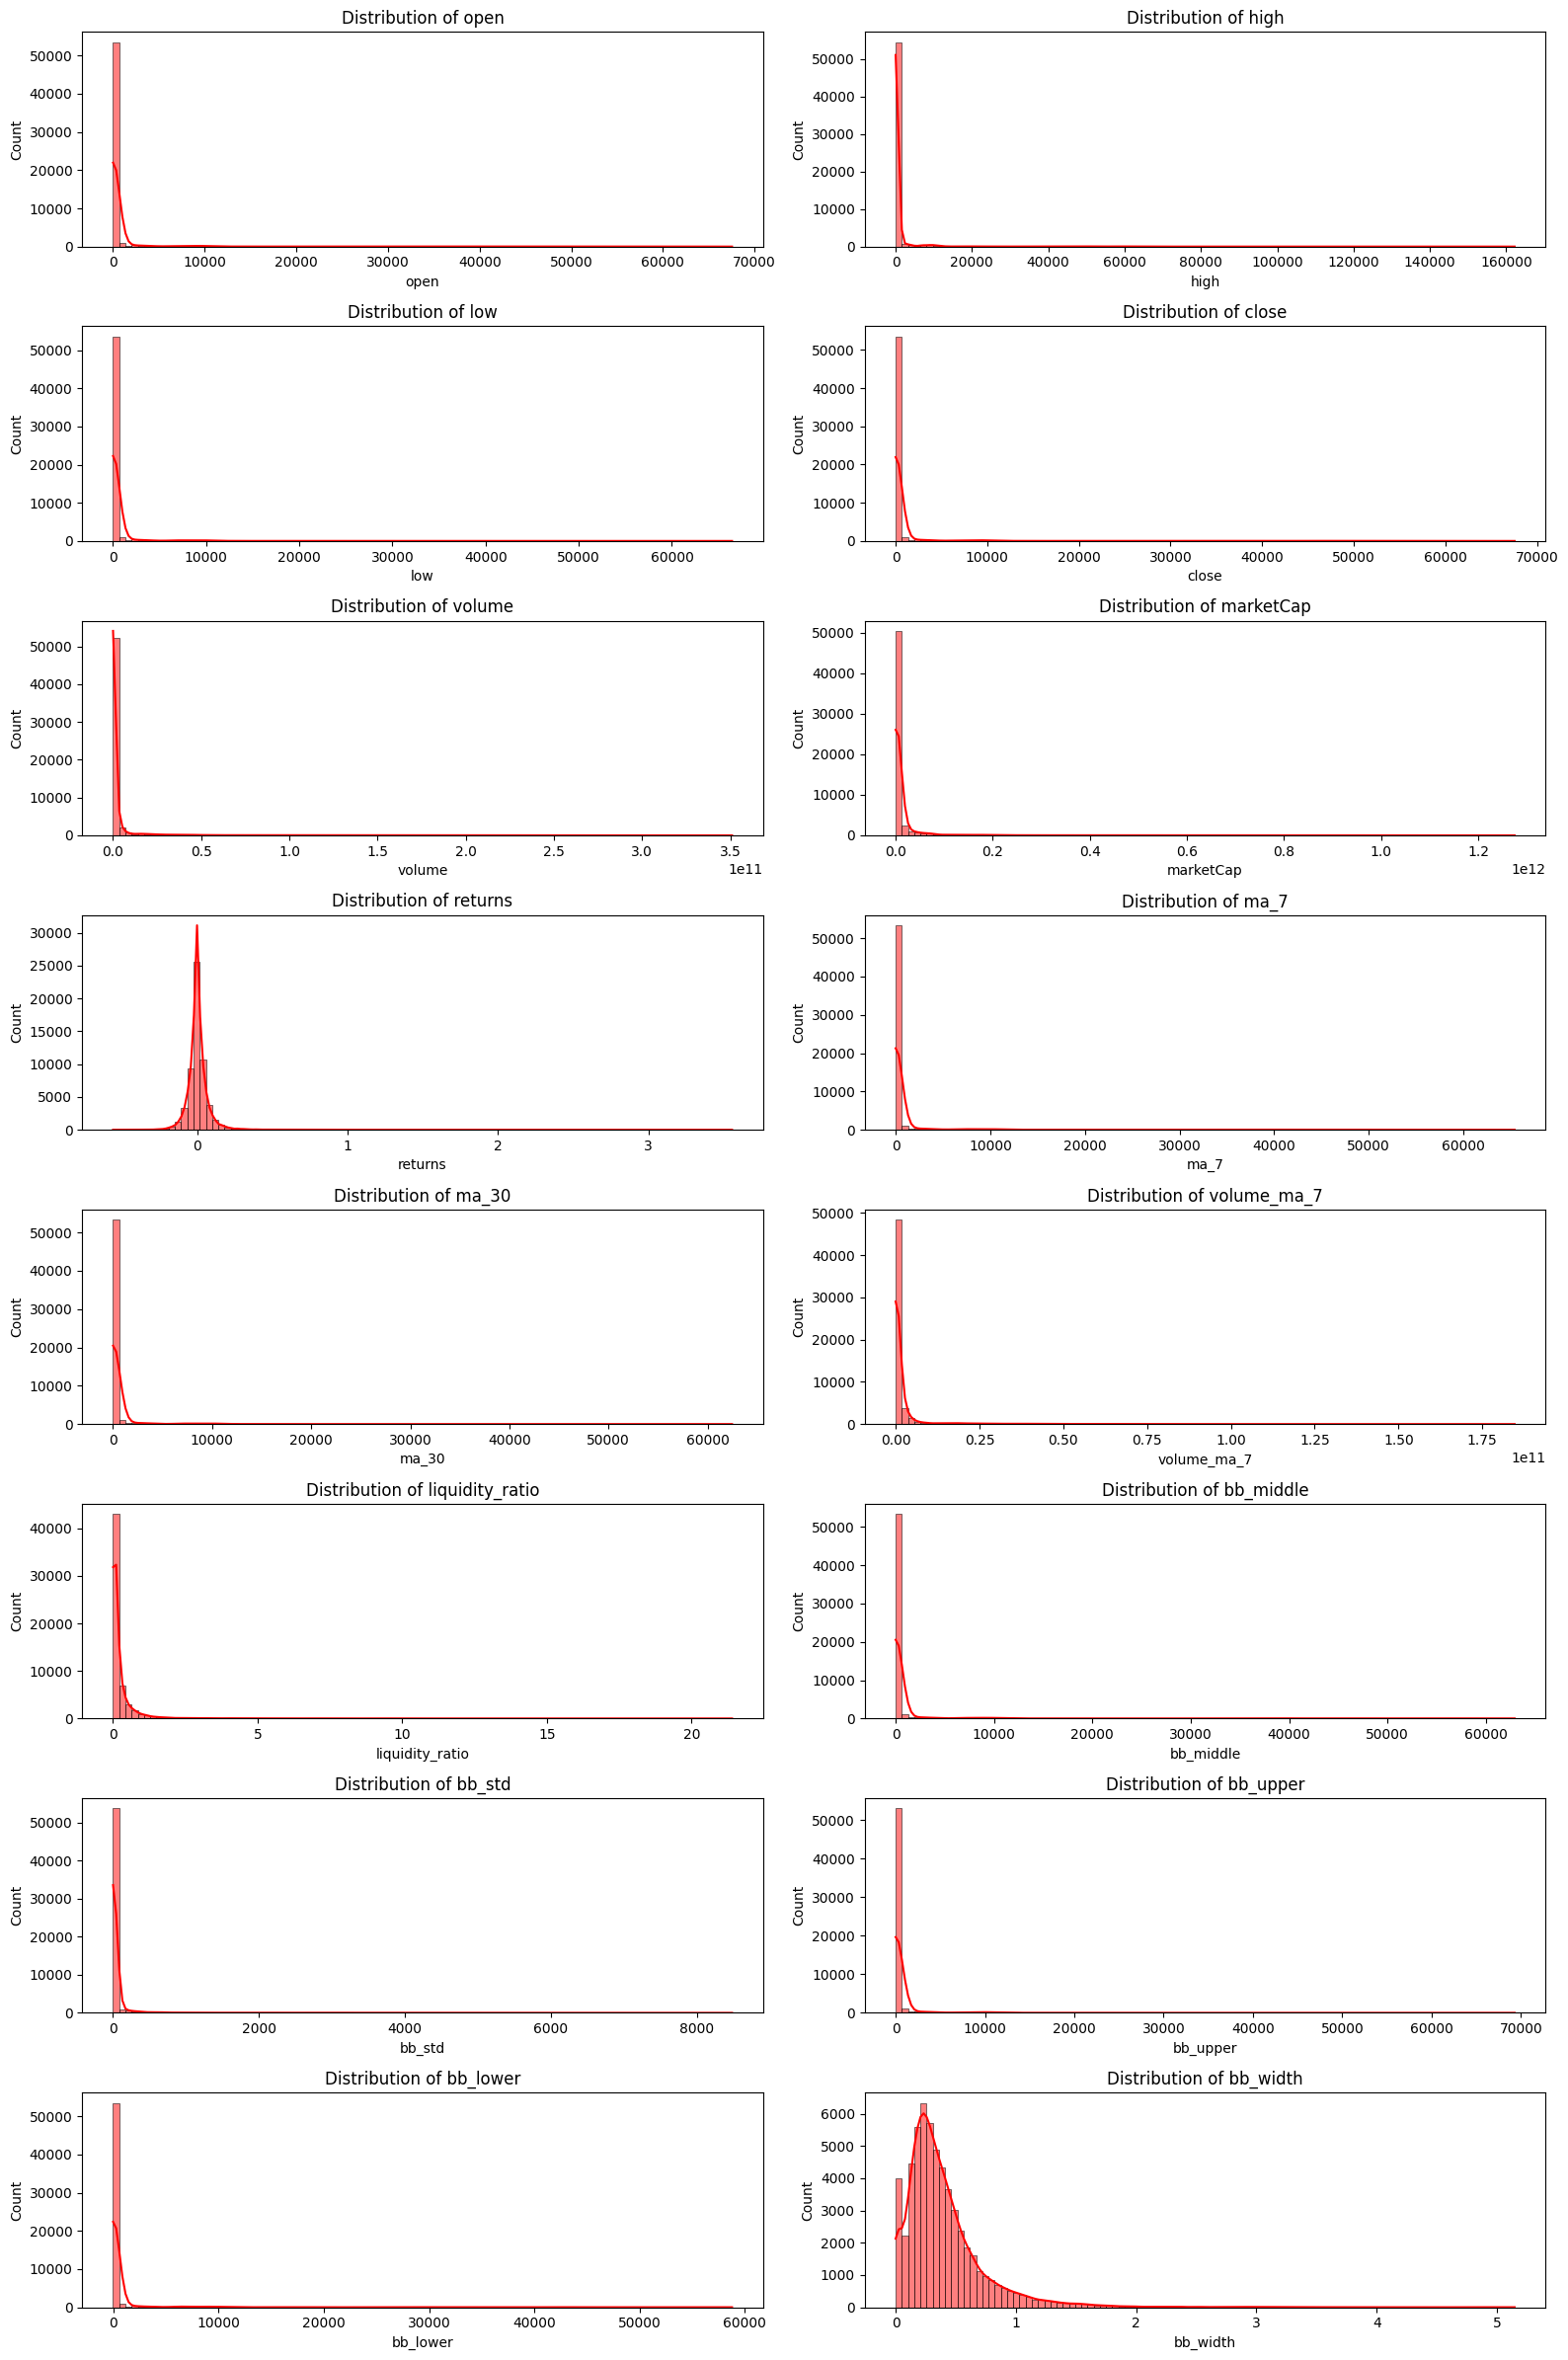

In [12]:
# Plot the distribution of numerical features
num_features = len(numerical_features)
cols = 2
rows = (num_features + cols - 1) // cols  # Calculate rows needed
plt.figure(figsize=(16, 3*rows))
for i in range(num_features):
    plt.subplot(rows, cols, i+1)
    sns.histplot(df[numerical_features[i]].dropna(), bins=100, kde=True,color='red')
    plt.title(f'Distribution of {numerical_features[i]}')
plt.tight_layout()
plt.show()

In [13]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
df.dropna(inplace=True)


Missing values per column:
open                 0
high                 0
low                  0
close                0
volume               0
marketCap            0
timestamp            0
crypto_name          0
date                 0
returns              0
volatility_7d        0
ma_7                 0
ma_30                0
volume_ma_7          0
liquidity_ratio      0
bb_middle            0
bb_std               0
bb_upper             0
bb_lower             0
bb_width             0
target_volatility    0
dtype: int64


In [14]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
volume               0
marketCap            0
timestamp            0
crypto_name          0
date                 0
returns              0
volatility_7d        0
ma_7                 0
ma_30                0
volume_ma_7          0
liquidity_ratio      0
bb_middle            0
bb_std               0
bb_upper             0
bb_lower             0
bb_width             0
target_volatility    0
dtype: int64

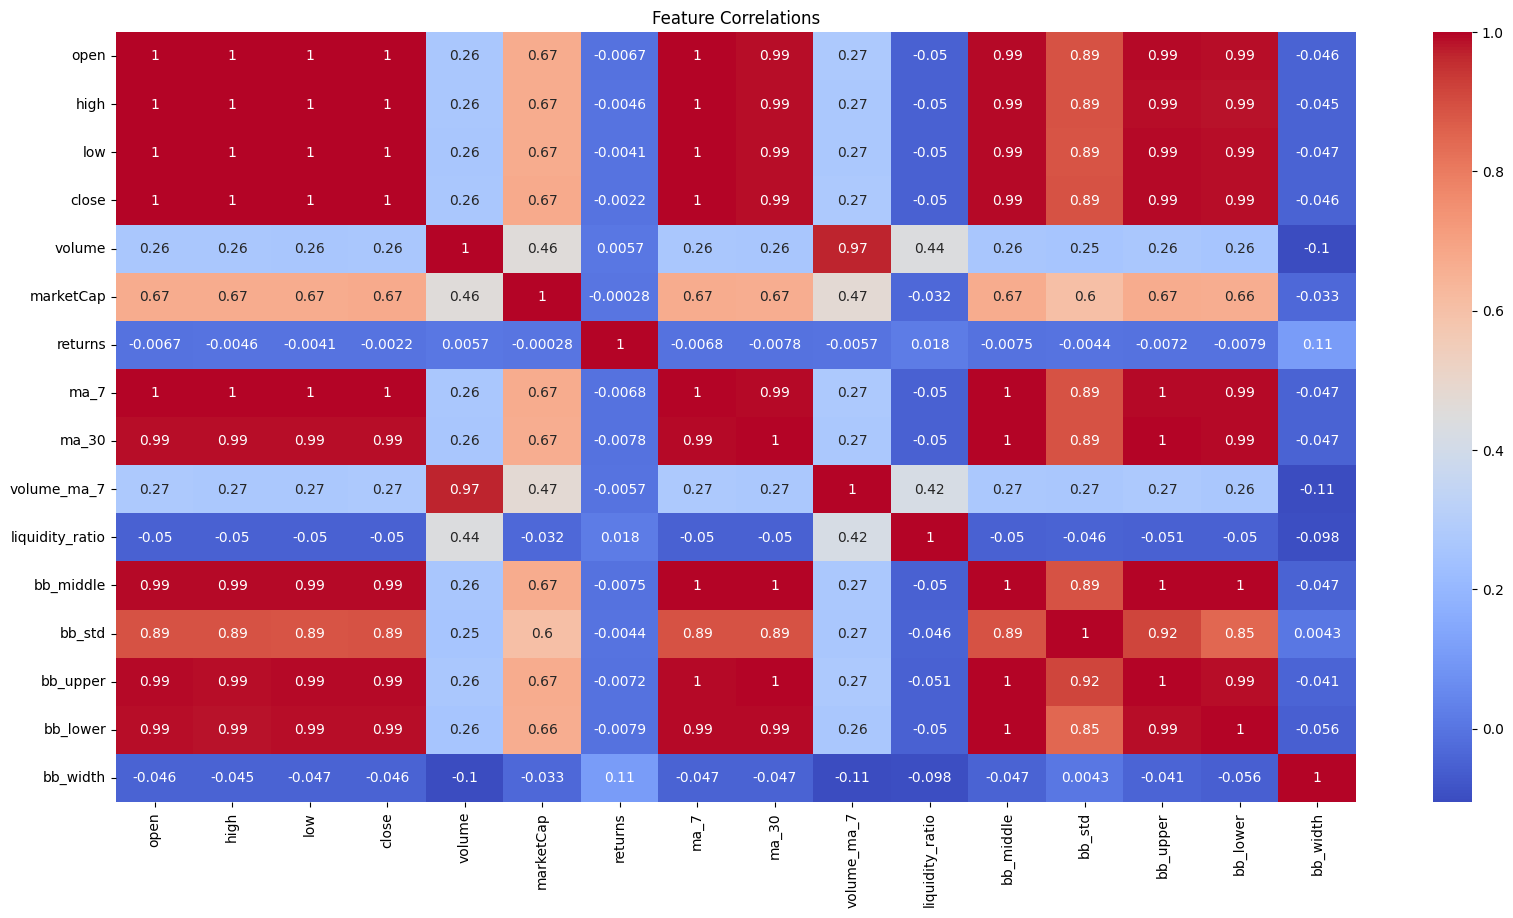

In [15]:
# Correlation Heatmap (on sample - now using defined numerical_features)
corr = df[numerical_features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.savefig('corr_heatmap.png')
plt.show()

In [16]:
df.head(1)

,open,high,low,close,volume,marketCap,timestamp,crypto_name,date,returns,...,ma_7,ma_30,volume_ma_7,liquidity_ratio,bb_middle,bb_std,bb_upper,bb_lower,bb_width,target_volatility
602,0.715041,0.773726,0.663839,0.709333,7.522600e+07,1.563634e+08,2019-08-15,Algorand,2019-08-15,-0.007983,...,0.782004,0.686864,8.249134e+07,0.481097,0.703278,0.098479,0.900235,0.506321,0.560112,0.042583


In [31]:
df.shape

(58095, 21)

In [28]:
# Step 5: Model Training

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# -----------------------------
# Feature separation
# -----------------------------
X = df.drop(columns=['target_volatility'])
y = df['target_volatility']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['crypto_name']

# -----------------------------
# Time-based split
# -----------------------------
train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# -----------------------------
# Preprocessing
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# -----------------------------
# Models
# -----------------------------
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='rmse',
        random_state=42
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        force_row_wise=True,
        verbosity=-1,
        random_state=42
    ),
    'LinearRegression': LinearRegression()
}

# -----------------------------
# Training & Evaluation
# -----------------------------
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    print(f"{name} - MAE: {results[name]['MAE']:.4f}, RMSE: {results[name]['RMSE']:.4f}, R2: {results[name]['R2']:.4f}")




RandomForest - MAE: 0.0067, RMSE: 0.0162, R2: 0.8612
GradientBoosting - MAE: 0.0141, RMSE: 0.0366, R2: 0.2957
XGBoost - MAE: 0.0084, RMSE: 0.0191, R2: 0.8071
LightGBM - MAE: 0.0070, RMSE: 0.0155, R2: 0.8740
LinearRegression - MAE: 0.0071, RMSE: 0.0143, R2: 0.8928


C:\Users\shouv\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [19]:
best_model = max(results, key=lambda x: results[x]['R2'])

print(f"\nBest Model: {best_model}")
for metric, value in results[best_model].items():
    print(f"{metric}: {value:.4f}")


Best Model: LinearRegression
MAE: 0.0071
RMSE: 0.0143
R2: 0.8928


In [21]:
# Hyper parameter tuning for LinearRegression with GridSearchCV
# Create a pipeline with preprocessing
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
	('preprocessor', preprocessor),
	('model', LinearRegression())
])

# Define hyperparameters for the model step
param_grid = {
	'model__fit_intercept': [True, False],
	'model__n_jobs':[-1,1,2,3,4,5,6,7,8,9,10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5] END model__fit_intercept=True, model__n_jobs=-1;, score=0.734 total time=   0.0s
[CV 2/5] END model__fit_intercept=True, model__n_jobs=-1;, score=0.824 total time=   0.0s
[CV 3/5] END model__fit_intercept=True, model__n_jobs=-1;, score=0.822 total time=   0.0s
[CV 4/5] END model__fit_intercept=True, model__n_jobs=-1;, score=0.847 total time=   0.0s
[CV 5/5] END model__fit_intercept=True, model__n_jobs=-1;, score=0.887 total time=   0.0s
[CV 1/5] END model__fit_intercept=True, model__n_jobs=1;, score=0.734 total time=   0.0s
[CV 2/5] END model__fit_intercept=True, model__n_jobs=1;, score=0.824 total time=   0.0s
[CV 3/5] END model__fit_intercept=True, model__n_jobs=1;, score=0.822 total time=   0.0s
[CV 4/5] END model__fit_intercept=True, model__n_jobs=1;, score=0.847 total time=   0.0s
[CV 5/5] END model__fit_intercept=True, model__n_jobs=1;, score=0.887 total time=   0.0s
[CV 1/5] END model__fit_intercept=True, mod

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'model__n_jobs': [-1, 1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [22]:
grid_search.best_params_

{'model__fit_intercept': True, 'model__n_jobs': -1}

In [23]:
grid_search.best_score_

np.float64(0.8228172465289969)

In [24]:
best_model_pred=grid_search.best_estimator_.predict(X_test)
print(f'Best model prediction: {best_model_pred}')



Best model prediction: [0.00378855 0.0043243  0.00296268 ... 0.10487738 0.11747431 0.12949147]


In [26]:
print(f'MAE: {mean_absolute_error(y_test, best_model_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, best_model_pred))}')
print(f'R2: {r2_score(y_test, best_model_pred)}')

MAE: 0.007149781271627245
RMSE: 0.014268857421772838
R2: 0.8928426552828871


C:\Users\shouv\AppData\Local\Temp\ipykernel_28852\3891184064.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=feature_importance, palette='Set2')


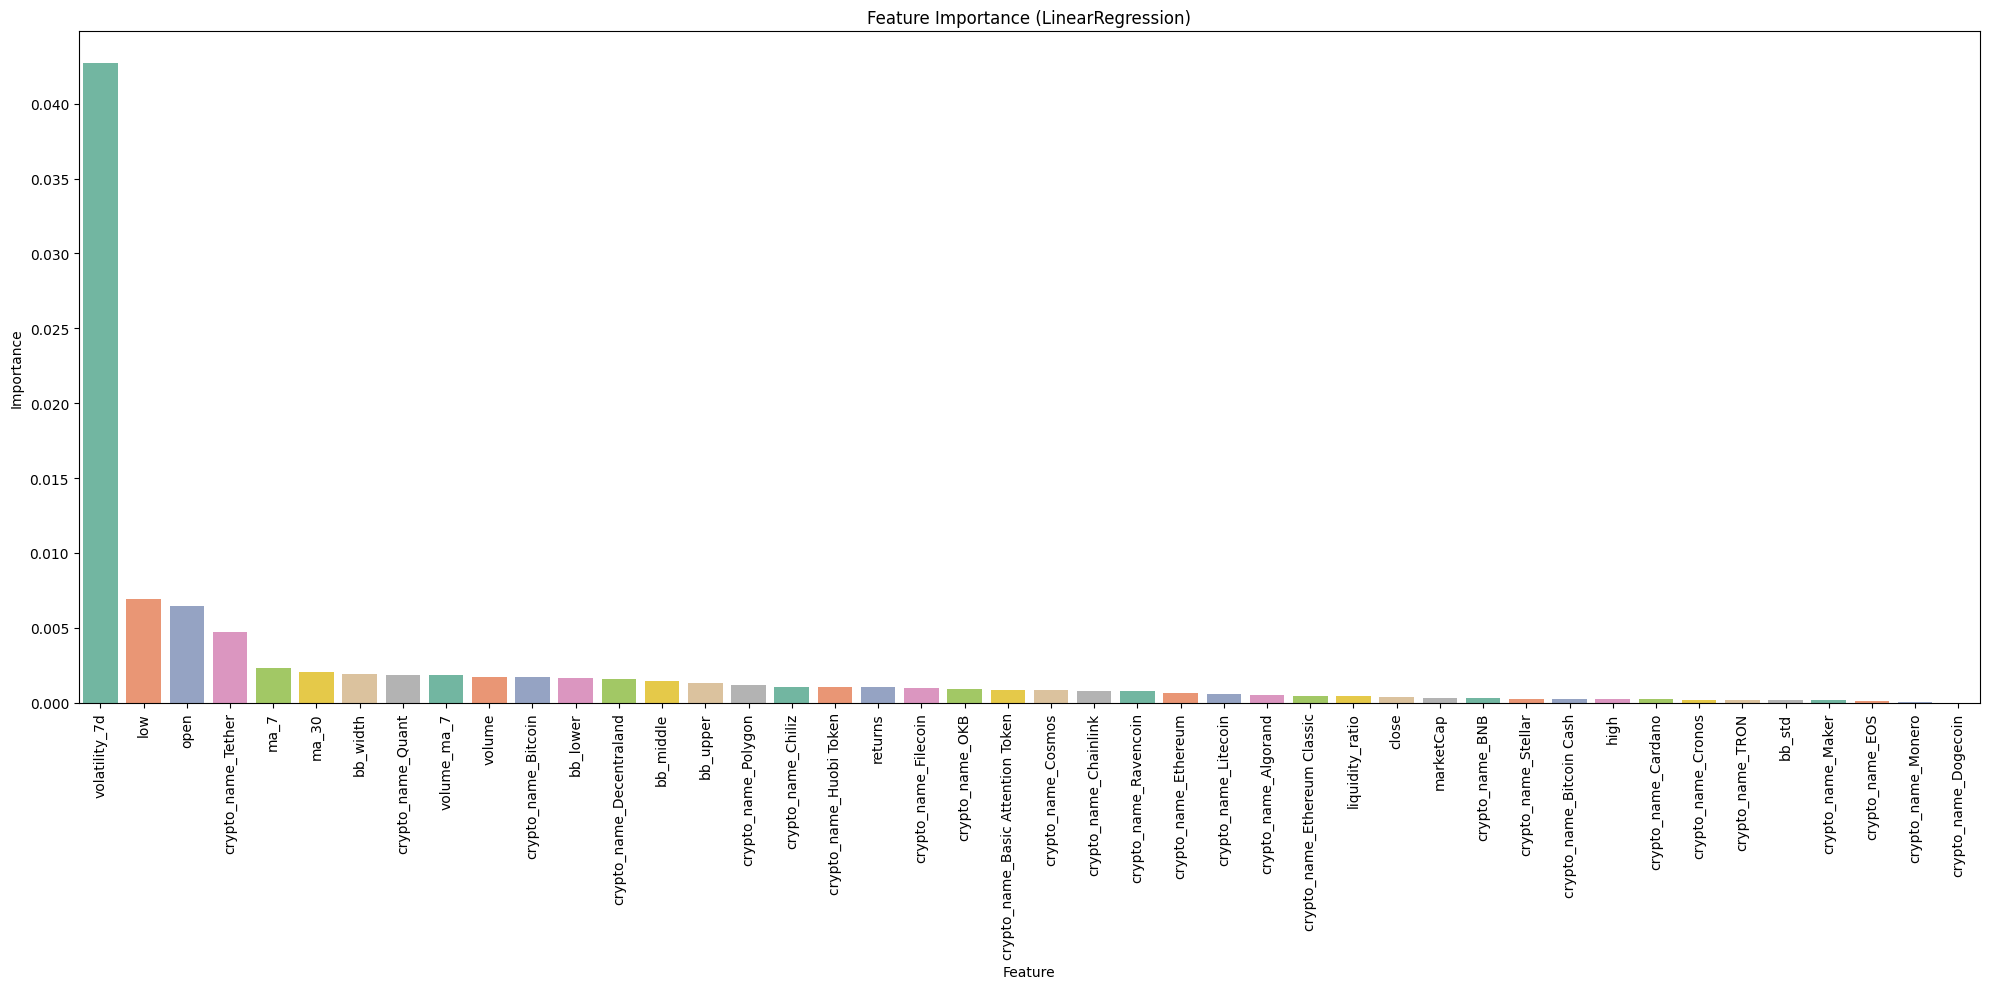

In [27]:
# Feature Importance Visualization
if best_model == 'LinearRegression':
    # For LinearRegression, use absolute coefficients
    # Get feature names after preprocessing
    preprocessor = pipe.named_steps['preprocessor']
    feature_names = (
        numerical_features + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(['crypto_name']))
    )
    coefficients = np.abs(pipe.named_steps['model'].coef_)
    feature_importance = pd.DataFrame(
        {'Feature': feature_names, 'Importance': coefficients}
    ).sort_values('Importance', ascending=False)
else:
    # For tree-based models, use feature_importances_
    feature_importance = pd.DataFrame(
        {'Feature': X.columns, 'Importance': pipe.named_steps['model'].feature_importances_}
    ).sort_values('Importance', ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x='Feature', y='Importance', data=feature_importance, palette='Set2')
plt.title(f'Feature Importance ({best_model})')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# **Project Documentation**

---

**High-Level Design (HLD)**

*  **System Architecture**: The solution follows a standard batch processing pipeline: 


   Data Ingestion (CSV) -> Preprocessing & Cleaning -> Feature Extraction -> Supervised Learning (Regression) -> Evaluation.

*  **Objective:** Predict target_volatility (next period's risk) using historical OHLCV data.

*  **Deployment Strategy:** The model is designed to be retrained weekly. For a production environment, it would be served via a REST API (using Flask/FastAPI) where a user sends a ticker symbol and the system returns the predicted volatility score.

**Low-Level Design (LLD)**
*  **Data Loader:** Reads dataset.csv, parses date column to datetime objects, and sorts data by crypto_name then date to ensure time-series integrity.

*  **Feature Engineer:**

   *  **Imputation:** Handles missing data by forward-filling or dropping (current implementation drops rows with NaNs generated by rolling windows).

   *  **Transformation:** Calculates pct_change for returns. Handles division by zero in liquidity_ratio by replacing inf with NaN.

*  **Model:**

   *  **Algorithm:** LinearRegression (chosen for robustness against outliers and non-linear feature interactions).

   *  **Hyperparameters:** n_estimators=100, random_state=42.

*  **Validation:**

   *  **Split Strategy:** Strict time-based splitting (Train: < 80th percentile date, Test: > 80th percentile) to prevent data leakage from the future.